In [1]:
import random
import numpy
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from fixedexpandergraphlayer import ExpanderLinear



random.seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Fetching Data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
training = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 train=True,
                                 transform=transform)
training_batches = torch.utils.data.DataLoader(training,
                                               batch_size=64,
                                               shuffle=True)
testing = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                download=True,
                                train=False,
                                transform=transform)
test_batches = torch.utils.data.DataLoader(testing,
                                           batch_size=64,
                                           shuffle=True)


#Learning Parameters
learning_rate = 0.005
rows = 1
epochs = 100                                                #For Debugging: Set to 10



#General network parameters
input_size = 28*28
output_size = 10
hidden_exponent=6                                            #For Debugging: Set to 3
hidden_size=2**hidden_exponent
inner_edges_exponent=2*hidden_exponent+3                     #For Debugging: Set to 2*hidden_exponent #needs to be >=2*hidden_exponent
number_of_inner_edges=2**inner_edges_exponent

train_loss = numpy.zeros((epochs,hidden_exponent))
test_loss = numpy.zeros((epochs,hidden_exponent))
legend_labels = numpy.empty(hidden_exponent,dtype='U15')

for graph_density_iteration in range(hidden_exponent):
    print("Starting graph density iteration number " + str(graph_density_iteration) + " of " + str(hidden_exponent-1) + ".")
    edges_per_node_exponent=graph_density_iteration+1
    edges_per_node=2**edges_per_node_exponent
    number_of_layers=2**(inner_edges_exponent-(hidden_exponent+edges_per_node_exponent))
    legend_labels[graph_density_iteration]="D=" + str(edges_per_node) + ", L=" + str(number_of_layers) + "."

    #Define adjacency matrix
    Mask=torch.zeros(hidden_size,hidden_size)
    temp_number_of_inner_edges=0
    #######################################################ADD Adjacency matrix here.
    index=0
    for n in range(hidden_size):
        for d in range(edges_per_node):
            #Mask[][]=
            if Mask[index][n]==0:
                temp_number_of_inner_edges=temp_number_of_inner_edges+1
            Mask[index][n] = 1
            index=(index+1)%hidden_size
    ########################################################
    print("Graph should have " + str(hidden_size*edges_per_node) + " edges and has " + str(temp_number_of_inner_edges) + " edges.")

    #Build Network
    model_list=[]
    model_list.append(nn.Linear(input_size, hidden_size))
    model_list.append(nn.ReLU())

    for l in range(number_of_layers):
        ExpanderLinear(Mask)
        model_list.append(nn.ReLU())

    model_list.append(nn.Linear(hidden_size, output_size))
    model_list.append(nn.LogSoftmax(dim=rows))
    model = nn.Sequential(*model_list)
    model.cuda()

    #Set Parameters for Optimization
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        if epoch%10 == 0:
            print("Starting epoch " + str(epoch) + " of " + str(epochs-1) + ".")
        running_loss = 0
        running_loss1 =0
        for images, labels in training_batches:
            images = images.to(device)
            labels = labels.to(device)
            # some setup
            ## Flatten the images
            images = images.view(images.shape[0], -1)
            ## Reset the optimizer
            optimizer.zero_grad()

            # forward pass
            output = model.forward(images)

            # back-propagation
            loss = criterion(output, labels)
            loss.backward()

            # take the next step
            optimizer.step()
            running_loss += loss.item()
        train_loss[epoch][graph_density_iteration]=running_loss / len(training_batches)
        for images1, labels1 in test_batches:
            images1 = images1.to(device)
            labels1 = labels1.to(device)
            # some setup
            ## Flatten the images
            images1 = images1.view(images1.shape[0], -1)
            ## Reset the optimizer
            optimizer.zero_grad()

            # forward pass
            output1 = model.forward(images1)

            # back-propagation
            loss1 = criterion(output1, labels1)
            loss1.backward()

            # take the next step
            optimizer.step()
            running_loss1 += loss1.item()
        test_loss[epoch][graph_density_iteration]=running_loss1 / len(test_batches)


plt.rcParams["figure.figsize"] = [8, 8]

#plot all train_loss in first plot and add legend
plt.figure(1)
for graph_density_iteration in range(hidden_exponent):
    plt.plot(train_loss[:,graph_density_iteration])
plt.title('Training Performance')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(legend_labels, loc='best')
plt.draw()
plt.show()
#plot all test_loss in second plot and add legend
plt.figure(2)
for graph_density_iteration in range(hidden_exponent):
    plt.plot(test_loss[:,graph_density_iteration])
plt.title('Testing Performance')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(legend_labels, loc='best')
plt.draw()
plt.show()

cuda:0
Starting graph density iteration number 0 of 5.
Graph should have 128 edges and has 128 edges.


C:\Arbeit\Workspace\AIMS Projects\deep-expander-networks-python-code\fixedexpandergraphlayer.py:92: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.weight.data,mode='fan_in')


Starting epoch 0 of 99.
Starting epoch 10 of 99.
Starting epoch 20 of 99.
Starting epoch 30 of 99.
Starting epoch 40 of 99.
Starting epoch 50 of 99.
Starting epoch 60 of 99.
Starting epoch 70 of 99.
Starting epoch 80 of 99.
Starting epoch 90 of 99.
Starting graph density iteration number 1 of 5.
Graph should have 256 edges and has 256 edges.
Starting epoch 0 of 99.
Starting epoch 10 of 99.
Starting epoch 20 of 99.
Starting epoch 30 of 99.
Starting epoch 40 of 99.
Starting epoch 50 of 99.
Starting epoch 60 of 99.
Starting epoch 70 of 99.
Starting epoch 80 of 99.
Starting epoch 90 of 99.
Starting graph density iteration number 2 of 5.
Graph should have 512 edges and has 512 edges.
Starting epoch 0 of 99.
Starting epoch 10 of 99.
Starting epoch 20 of 99.
Starting epoch 30 of 99.
Starting epoch 40 of 99.
Starting epoch 50 of 99.
Starting epoch 60 of 99.
Starting epoch 70 of 99.
Starting epoch 80 of 99.
Starting epoch 90 of 99.
Starting graph density iteration number 3 of 5.
Graph should ha

<Figure size 800x800 with 1 Axes>

<Figure size 800x800 with 1 Axes>

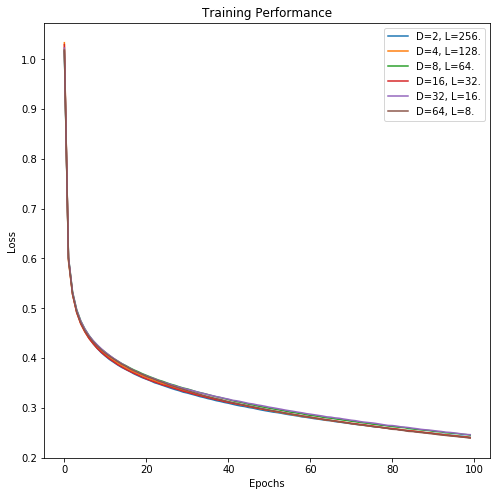

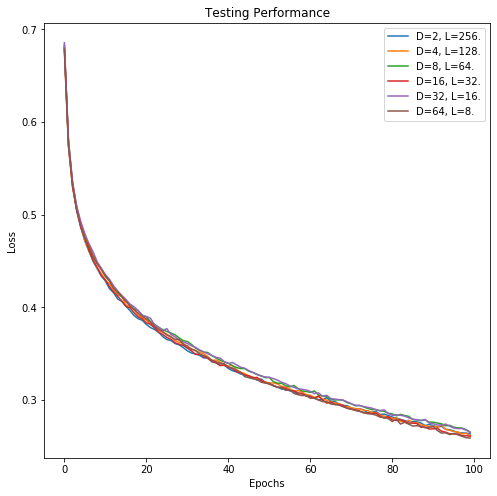

In [10]:
plt.rcParams["figure.figsize"] = [8, 8]

#plot all train_loss in first plot and add legend
plt.figure(1)
for graph_density_iteration in range(hidden_exponent):
    plt.plot(train_loss[:,graph_density_iteration])
plt.title('Training Performance')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(legend_labels, loc='best')
plt.draw()
plt.show()
#plot all test_loss in second plot and add legend
plt.figure(2)
for graph_density_iteration in range(hidden_exponent):
    plt.plot(test_loss[:,graph_density_iteration])
plt.title('Testing Performance')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(legend_labels, loc='best')
plt.draw()
plt.show()

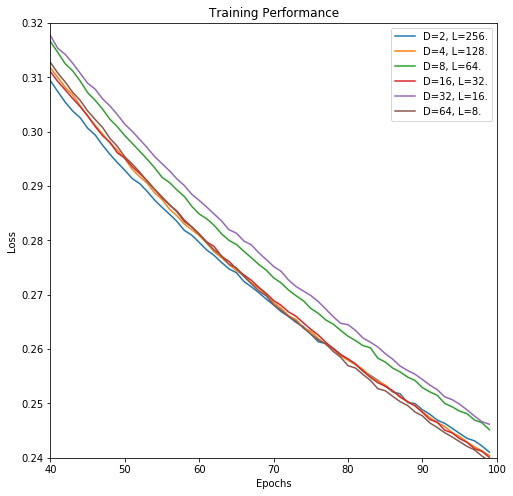

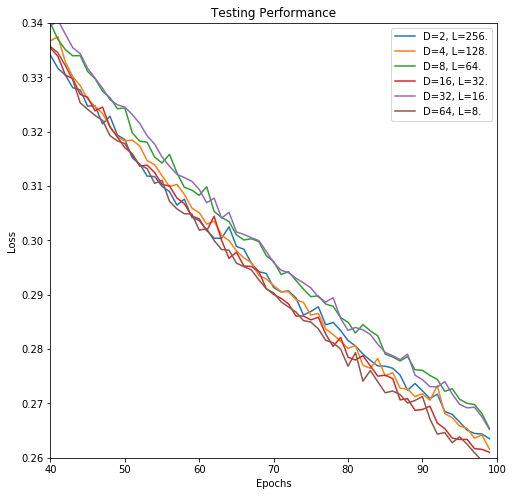

In [31]:
plt.rcParams["figure.figsize"] = [8, 8]

#plot all train_loss in first plot and add legend
plt.figure(1)
for graph_density_iteration in range(hidden_exponent):
    plt.plot(train_loss[:,graph_density_iteration])
plt.title('Training Performance')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(legend_labels, loc='best')
plt.xlim((40,100))
plt.ylim((0.24,0.32))
plt.draw()
plt.show()
#plot all test_loss in second plot and add legend
plt.figure(2)
for graph_density_iteration in range(hidden_exponent):
    plt.plot(test_loss[:,graph_density_iteration])
plt.title('Testing Performance')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(legend_labels, loc='best')
plt.ylim((0.26,0.34))
plt.xlim((40,100))
plt.draw()
plt.show()